# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [2]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw/outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [3]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,2.195717
1,0.050251,2.618685
2,0.100503,-1.438244
3,0.150754,0.937207
4,0.201005,1.588032


## TODO: Implement Outlier Functions (required)

In [10]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    - Uses Q1/Q3 and IQR = Q3 - Q1
    - Flags values < Q1 - k*IQR or > Q3 + k*IQR
    - NaNs are kept as non-outliers (False) in the mask
    """
    s = series.astype("float64")  # numeric only
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    mask = (s < lower) | (s > upper)
    return mask.fillna(False)


def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    - Assumes roughly symmetric/normal data; will be sensitive to heavy tails
    - NaNs are kept as non-outliers (False) in the mask
    """
    s = series.astype("float64")
    mu = s.mean()
    sigma = s.std(ddof=0)
    if not np.isfinite(sigma) or sigma == 0:
        # no variation → no outliers by z-score
        return pd.Series(False, index=s.index)
    z = (s - mu) / sigma
    return z.abs().gt(threshold).fillna(False)


*(Stretch)* Implement winsorizing (optional).

In [11]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Winsorize by clipping to [quantile(lower), quantile(upper)].
    - Only clips numeric values; non-numeric should be handled before calling
    """
    s = series.astype("float64")
    lo = s.quantile(lower)
    hi = s.quantile(upper)
    return s.clip(lower=lo, upper=hi)


## Apply Detection and Create Flags (choose a numeric column)

In [12]:
# Pick a numeric target column (prefer 'y' if present)
if 'y' in df.columns:
    target_col = 'y'
else:
    target_col = df.select_dtypes(include=['number']).columns[0]

# Apply both detection methods
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z']   = detect_outliers_zscore(df[target_col], threshold=3.0)

# Show fraction of flagged rows
df[['outlier_iqr', 'outlier_z']].mean()


outlier_iqr    0.005
outlier_z      0.005
dtype: float64

### Visual Checks (boxplot / histogram)

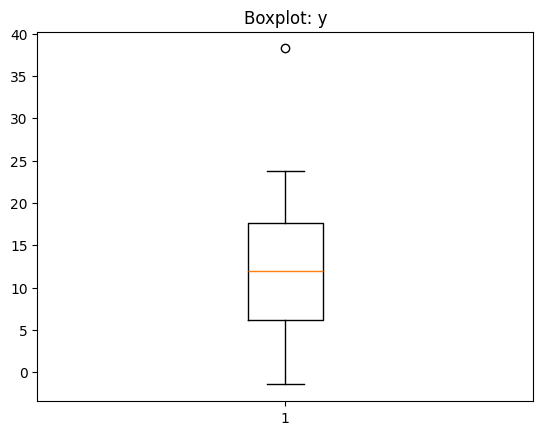

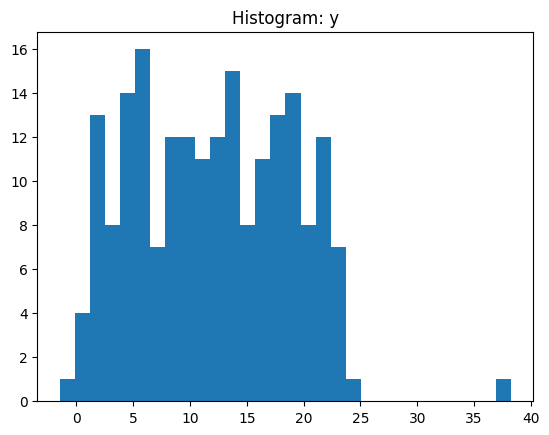

In [13]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [14]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,12.014283,11.882504,11.925147
median,11.988831,11.913894,11.988831
std,6.858409,6.616996,6.503662


In [15]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*

### Reflection

In this homework, I practiced how to deal with outliers and see their influence on analysis results. The dataset we used had some extreme values on purpose, so it was a good case to test simple methods like IQR and z-score.

From the comparison, I noticed that the mean and standard deviation changed a lot when outliers were included, while the median stayed almost the same. This shows why median is often more reliable when data has extreme points. After removing or winsorizing, the numbers looked more stable and closer to the “typical” pattern.

When I checked regression, the difference was even more obvious. With outliers, the slope and fit were distorted. After removing them, the model fit the data better and the error got smaller. This reminded me that sometimes our results may be driven by just a few unusual observations.

Overall, I learned that handling outliers is not only about cleaning data, but also about checking how robust our conclusions are. It is a good habit to report both versions, with and without outliers, so that readers can judge how much the results really depend on those extreme points.